In [1]:
import numpy as np
from matplotlib.pyplot import plot 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = np.linspace(1,100,100)
X.shape

(100,)

In [3]:
X = np.c_[X, np.ones(100)]
X.shape

(100, 2)

In [4]:
w = np.array([3,2])
w.shape

(2,)

In [5]:
Y = X.dot(w)
Y

array([  5.,   8.,  11.,  14.,  17.,  20.,  23.,  26.,  29.,  32.,  35.,
        38.,  41.,  44.,  47.,  50.,  53.,  56.,  59.,  62.,  65.,  68.,
        71.,  74.,  77.,  80.,  83.,  86.,  89.,  92.,  95.,  98., 101.,
       104., 107., 110., 113., 116., 119., 122., 125., 128., 131., 134.,
       137., 140., 143., 146., 149., 152., 155., 158., 161., 164., 167.,
       170., 173., 176., 179., 182., 185., 188., 191., 194., 197., 200.,
       203., 206., 209., 212., 215., 218., 221., 224., 227., 230., 233.,
       236., 239., 242., 245., 248., 251., 254., 257., 260., 263., 266.,
       269., 272., 275., 278., 281., 284., 287., 290., 293., 296., 299.,
       302.])

In [6]:
X[:,0] += np.random.normal(size=(X[:,0].shape))*3 #添加噪声
X.shape

(100, 2)

In [7]:
Y = Y.reshape(100,1)
Y.shape

(100, 1)

Text(0, 0.5, 'Y')

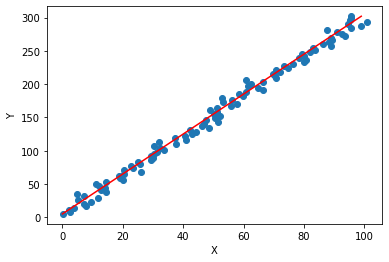

In [8]:
plt.scatter(X[:,0],Y)
plot(np.arange(0,100).reshape(100,1),Y,"r")
plt.xlabel("X")
plt.ylabel("Y")

In [9]:
w = np.random.random(size=(2,1))
epoch = 100
beta = 1e-7
losses = []
for _ in range(epoch):
    dw = -2*X.T.dot(Y-X.dot(w))
    w = w - beta*dw
    losses.append((Y-X.dot(w)).T.dot(Y-X.dot(w)).reshape(-1))
w

array([[3.03439928],
       [0.06276662]])

Text(0, 0.5, 'loss')

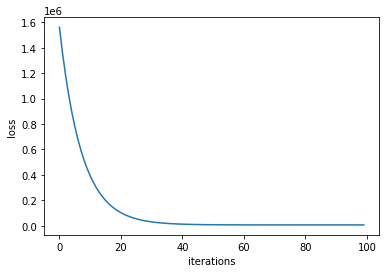

In [10]:
#loss变化
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')

In [11]:
#当然也可以直接求显式解
w=np.linalg.pinv(X).dot(Y)
w

array([[2.96919336],
       [4.5773729 ]])

Text(0, 0.5, 'Y')

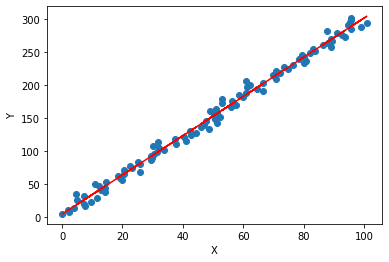

In [12]:
#可视化,拟合直线
plt.scatter(X[:,0],Y)
plt.plot(X[:,0],X.dot(w),'r')
plt.xlabel('X')
plt.ylabel('Y')

In [13]:
def sign(x):
    """
    符号函数
    :param x:
    :return:
    """
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

In [14]:
class Linerregression(object):
    def __init__(self,solver='sgd',fit_intercept=True,if_standard=True,epochs=10,
                 beta=1e-2,batch_size=1,l1_ratio=None,l2_ratio=None):
        self.w = None
        self.solver = solver
        self.fit_intercept = fit_intercept
        self.if_standard = if_standard
        if self.if_standard:
            self.feature_mean = None
            self.feature_std = None
        self.epochs = epochs
        self.beta = beta
        self.batch = batch_size
        self.l1_ratio = l1_ratio
        self.l2_ratio = l2_ratio
         # 注册sign函数
        self.sign_func = np.vectorize(sign)

        
    def init_params(self,n_feature):
        self.w = np.random.random(size=(n_feature,1))
        
    def  _fit_closed_form_solution(self, x, y, sample_weight):
        if self.l1_ratio is None and self.l2_ratio is None:
            self.w = np.linalg.pinv(x).dot(y) 
        elif self.l1_ratio is None and self.l2_ratio is not None:
            self.w = np.linalg.inv(x.T.dot(x)+ self.l2_ratio*
                                   np.eye(x.shape[1])).dot(x.T).dot(y)
        else:
            self.w = self._fit_sgd(x,y,sample_weight)
            
    def _fit_sgd(self,x,y,sample_weight):
        x_y = np.c_[x,y]
        for _ in range(self.epochs):
            np.random.shuffle(x_y)
            for index in range(x_y.shape[0]//self.batch):
                batch_x_y = x_y[self.batch*index:self.batch*(index+1)]
                batch_x = batch_x_y[:,:-1]
                batch_y = batch_x_y[:,-1]
                sample_weight_diag = np.diag(sample_weight[self.batch*index:self.batch*(index+1)])
                sample_weight_mean = np.mean(sample_weight[self.batch*index:self.batch*(index+1)])
                dw = -2*batch_x.T.dot(sample_weight_diag).dot(batch_y-batch_x.dot(self.w))/self.batch
                 # 添加l1和l2的部分
                # 添加l1和l2的部分
                dw_reg = np.zeros(shape=(x.shape[1] - 1, 1))
                if self.l1_ratio is not None:
                    dw_reg += sample_weight_mean * self.l1_ratio * self.sign_func(self.w[:-1]) / self.batch
                if self.l2_ratio is not None:
                    dw_reg += 2 * sample_weight_mean * self.l2_ratio * self.w[:-1] / self.batch
                dw_reg = np.concatenate([dw_reg, np.array([[0]])], axis=0)
                dw += dw_reg

                self.w = self.w - self.beta * dw
                
    def fit(self,x ,y,sample_weight=None):
        n_sample = x.shape[0]
        if sample_weight is None:
            sample_weight = np.array([1.0] * n_sample)
        # check sample_weight
        if len(sample_weight) != n_sample:
            raise Exception('sample_weight size error:', len(sample_weight))
        # 是否归一化feature
        if self.if_standard:
            self.feature_mean = np.mean(x, axis=0)
            self.feature_std = np.std(x, axis=0) + 1e-8
            x = (x-self.feature_mean)/self.feature_std
         # 是否训练bias
        if self.fit_intercept:
            x = np.c_[x, np.ones_like(y)]
         # 初始化参数
        self.init_params(x.shape[1])
        # 训练模型
        if self.solver == 'closed_form':
            self._fit_closed_form_solution(x, y, sample_weight)
        elif self.solver == 'sgd':
            self._fit_sgd(x, y, sample_weight)
            
    def get_params(self):
        if self.fit_intercept:
            w = self.w[:-1]
            b = self.w[-1]
        else:
            w = self.w
            b = 0
        if self.if_standard:
            w = w / self.feature_std.reshape(-1, 1)
            b = b - w.T.dot(self.feature_mean.reshape(-1, 1))
        return w.reshape(-1), b
    
    def predict(self,x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        if self.if_standard:
            x = (x - self.feature_mean) / self.feature_std
        if self.fit_intercept:
            x = np.c_[x, np.ones(shape=x.shape[0])]
        return x.dot(self.w)
    
    def plot_fit_boundary(self, x, y):
        """
        绘制拟合结果
        :param x:
        :param y:
        :return:
        """
        plt.scatter(x[:, 0], y)
        plt.plot(x[:, 0], self.predict(x), 'r')
    

In [15]:

Y = Y.reshape(100, 1)
Lr = Linerregression(solver='sgd')
Lr.fit(X[:,:-1],Y)
predict = Lr.predict(X[:,:-1])
print("w","b",Lr.get_params())
print(np.std(Y-predict))


w b (array([2.98051821]), array([[4.54464145]]))
7.546942944600509


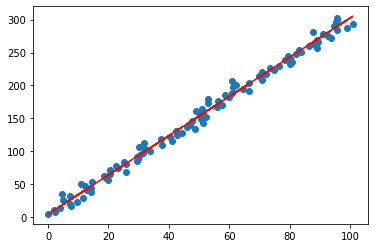

In [16]:
Lr.plot_fit_boundary(X[:,:-1],Y)

In [17]:
#测试
Lr=Linerregression(solver='closed_form')
Lr.fit(X[:,:-1],Y)
predict=Lr.predict(X[:,:-1])
#查看w
print('w',Lr.get_params())
#查看标准差
np.std(Y-predict)

w (array([2.96919336]), array([[4.5773729]]))


7.539766540005765

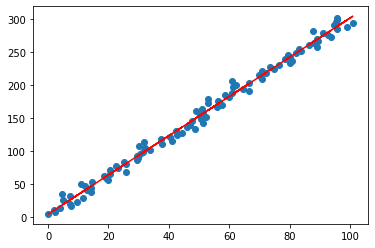

In [18]:
#可视化结果
Lr.plot_fit_boundary(X[:,:-1],Y)

In [19]:
#与sklearn对比
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X[:,:-1],Y)
predict=lr.predict(X[:,:-1])
#查看w,b
print('w:',lr.coef_,'b:',lr.intercept_)
#查看标准差
np.std(Y-predict)

w: [[2.96919336]] b: [4.5773729]


7.539766540005763

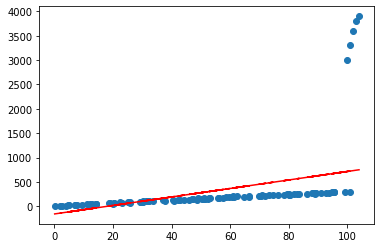

In [20]:
X=np.concatenate([X,np.asanyarray([[100,1],[101,1],[102,1],[103,1],[104,1]])])
Y=np.concatenate([Y,np.asanyarray([[3000],[3300],[3600],[3800],[3900]])])
lr=Linerregression(l1_ratio=100)
lr.fit(X[:,:-1],Y)
lr.plot_fit_boundary(X[:,:-1],Y)

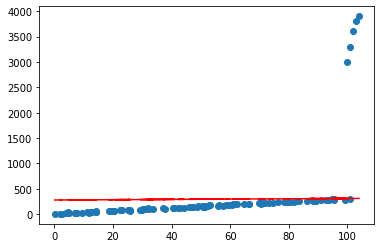

In [21]:
ridge=Linerregression(l2_ratio=10)
ridge.fit(X[:,:-1],Y)
ridge.plot_fit_boundary(X[:,:-1],Y)

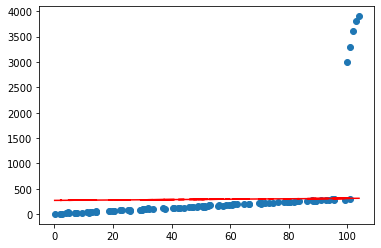

In [22]:
elastic=Linerregression(l1_ratio=100,l2_ratio=10)
elastic.fit(X[:,:-1],Y)
elastic.plot_fit_boundary(X[:,:-1],Y)